Example notebook as part of my internship project in Spring 2021 at DHI GRAS about Volume Estimation of Supraglacial Lakes in Greenland.

In [97]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
from astropy.time import Time
import readers as rd
import os
from scipy.stats import norm, kurtosis
from scipy.optimize import curve_fit
import time
from sklearn.metrics import r2_score

Loading raw ICESat-2 ATL03 dataset

In [98]:
data_loc='E:/ATL03/' # update to where you downloaded the data
for file in os.listdir(data_loc):
    if file.startswith('processed_ATL03_20190814035453_07190403_003_01.h5') and file.endswith('.h5'):
        fname = file
print(fname)
f = h5py.File(data_loc+fname, 'r')
beam='gt3l'
dfATL03=rd.getATL03(f,beam)
dfATL03['AT_dist']=dfATL03.x-dfATL03.x.values[0]
dfATL03 = dfATL03.loc[(dfATL03["AT_dist"] > 5000) & (dfATL03["AT_dist"] < 10000)]
print("Photons in dataframe:", len(dfATL03))

processed_ATL03_20190814035453_07190403_003_01.h5
Photons in dataframe: 26897


Surf-function Estimates the surface of the icesheet/lakes. To find the depth of supraglacial lakes one must first define the surface of the lakes. Afterwards searches for photons below the surface to estimate depth of lake. 

In [121]:
def Surf(dfATL03, window_width):
    startTime = time.time()
    
    AT_dist_values = dfATL03['AT_dist'].values # Along Track Distance Values
    AT_dist_totmax = AT_dist_values.max()
    AT_dist_totmin = AT_dist_values.min()
    
    window_bed_width = 10

    heights_values = dfATL03['heights'].values

    lats = dfATL03['lats'].values
    lons = dfATL03['lons'].values
    
    windows = np.arange(AT_dist_totmin, AT_dist_totmax, 10).tolist()
    a = np.empty(len(windows))
    b = np.empty(len(windows))
    c = np.empty(len(windows))
    d = np.empty(len(windows))
    e = np.empty(len(windows))
    f = np.empty(len(windows))
    g = np.empty(len(windows))
    h = np.empty(len(windows))
    
    i = 0
    #Iterate through rows in dataframe
    for window_center in windows:    

        #---------------
        #Step 1: Window Boundries
        #---------------

        #Get minimum window boundries
        min_dist = window_center - window_width
        min_dist_array = np.where(AT_dist_values > min_dist)
        min_dist_row = min_dist_array[0][0]

        #Get maximum window boundries
        max_dist = window_center + window_width
        if max_dist < AT_dist_values[-1]:
            max_dist_array = np.where(AT_dist_values > max_dist)
            max_dist_row = max_dist_array[0][0]
        else:
            max_dist = AT_dist_values[-1] 

        #Get window center lat & long for plotting later        
        idx = (np.abs(AT_dist_values - window_center)).argmin()
        lat = lats[idx]
        lon = lons[idx]

        #Select photons AT_dist & heights within boundries
        window_AT_dist = AT_dist_values[min_dist_row:max_dist_row]    
        window_heights = heights_values[min_dist_row:max_dist_row]

        print("WC", window_center)
        print("min", window_AT_dist.min())
        print("max", window_AT_dist.max())

        w_len = len(window_heights)
        if w_len > window_width:
            #---------------
            #Step 2: Basic stats
            #---------------
            #Basic stats - mean & std
            mean = window_heights.mean()
            std = window_heights.std()

            #Polyfit to calulate slope
            coef = np.polyfit(window_AT_dist, window_heights, 1) 
            yfit = np.polyval(coef, window_AT_dist)
            residual = np.sum((window_heights-yfit)**2)
            slope = coef[0]
            threshold = window_width*20
            if residual > threshold:
                lakesurf = 1
            else:
                lakesurf = 0


            #------------------
            #Step 3: Find boundries of bins 
            #------------------

            #Parameters
            Dataset = window_heights
            binwidth = 0.2

            #Binning Data
            values, bins = np.histogram(Dataset, bins=np.arange(Dataset.min(), Dataset.max() + binwidth, binwidth))

            #Find mean of bin with highest count
            elem = np.argmax(values)
            maxbin = bins[elem]
            Lake_surf_mean = maxbin + (binwidth/2)
            Lake_surf_min = Lake_surf_mean - 0.5
            Lake_surf_max = Lake_surf_mean + 0.5

            #Slope of surf
            yval = [element for idx, element in enumerate(window_heights) if (element > Lake_surf_min) & (element < Lake_surf_max)]
            yindex = [idx for idx, element in enumerate(window_heights) if (element > Lake_surf_min) & (element < Lake_surf_max)]
            xval = [window_AT_dist[i1] for i1 in yindex]
            arr1 = np.array(yval)
            arr2 = np.array(xval)       

            coef1 = np.polyfit(arr2, arr1, 1) 
            yfit1 = np.polyval(coef1, arr2)
            residual1 = np.sum((arr1-yfit1)**2)
            slope3 = coef1[0]

            #Extract surface of lake
            Surf_heights = window_heights[(window_heights > Lake_surf_min) & (window_heights < Lake_surf_max)]
            Surf_heights_mean = Surf_heights.mean()
            
            #Bed_Heights
            #####
            #Get minimum window boundries
            min_dist_bed = window_center - window_bed_width - 1
            min_dist_bed_array = np.where(AT_dist_values > min_dist_bed)
            min_dist_bed_row = min_dist_bed_array[0][0]

            #Get maximum window boundries
            max_dist_bed = window_center + window_bed_width - 1
            if max_dist_bed < AT_dist_values[-1]:
                max_dist_bed_array = np.where(AT_dist_values > max_dist_bed)
                max_dist_bed_row = max_dist_bed_array[0][0]
            else:
                max_dist_bed = AT_dist_values[-1] 
                
            #Select photons AT_dist & heights within boundries
            window_AT_dist_bed = AT_dist_values[min_dist_bed_row:max_dist_bed_row]    
            window_heights_bed = heights_values[min_dist_bed_row:max_dist_bed_row]
            print("len whb",len(window_heights_bed))
            Bed_heights = window_heights_bed[window_heights_bed < Lake_surf_min - 1.5]
                     
            Bed_heights_std = Bed_heights.std()

            
            print("len bh",len(Bed_heights))
            if len(Bed_heights) > (window_bed_width*2):
#            Bed_heights = window_heights[window_heights < Lake_surf_min]
                Bed_heights_mean = Bed_heights.mean()            
                
                binwidth_bed = 0.5
                values_bed, bins_bed = np.histogram(Bed_heights, bins=np.arange(Bed_heights.min(), Bed_heights.max() + binwidth_bed, binwidth_bed))            

                elem_bed = np.argmax(values_bed)
                maxbin = bins_bed[elem_bed]
                Lake_bed_mean = maxbin + (binwidth_bed/2)
                Lake_bed_min = Lake_bed_mean - 2
                Lake_bed_max = Lake_bed_mean + 2

                Bed_heights2 = window_heights[(window_heights > Lake_bed_min) & (window_heights < Lake_bed_max)]
                Bed_heights_mean2 = Bed_heights2.mean()

                #Slope of bed
                yval_bed = [element for idx, element in enumerate(window_heights) if (element > Lake_bed_min) & (element < Lake_bed_max)]
                yindex_bed = [idx for idx, element in enumerate(window_heights) if (element > Lake_bed_min) & (element < Lake_bed_max)]
                xval_bed = [window_AT_dist[i2] for i2 in yindex_bed]

                arr1_bed = np.array(yval_bed)
                arr2_bed = np.array(xval_bed)
                print("min x", arr2_bed.min())
                print("max x", arr2_bed.max())
                  
                arr1_bed = np.array(yval_bed)
                arr2_bed = np.array(xval_bed)
                print("min x", arr2_bed.min())
                print("max x", arr2_bed.max())

                #Get minimum window boundries
                min_dist_bed = window_center - window_bed_width - 1
                min_dist_bed_array = np.where(AT_dist_values > min_dist_bed)
                min_dist_bed_row = min_dist_bed_array[0][0]

                #Get maximum window boundries
                max_dist_bed = window_center + window_bed_width - 1
                if max_dist_bed < AT_dist_values[-1]:
                    max_dist_bed_array = np.where(AT_dist_values > max_dist_bed)
                    max_dist_bed_row = max_dist_bed_array[0][0]
                else:
                    max_dist_bed = AT_dist_values[-1] 
                
                #Select photons AT_dist & heights within boundries
                window_AT_dist_bed = AT_dist_values[min_dist_bed_row:max_dist_bed_row]    
                window_heights_bed = heights_values[min_dist_bed_row:max_dist_bed_row]

                Bed_heights = window_heights_bed[window_heights_bed < Lake_surf_min]
            
            
                ##################################################################
            
            

                coef1_bed = np.polyfit(arr2_bed, arr1_bed, 1) 
                yfit1_bed = np.polyval(coef1_bed, arr2_bed)
                residual1_bed = np.sum((arr1_bed-yfit1_bed)**2)
                slope3_bed = coef1_bed[0]
                new_bed_mean = yfit1_bed.mean()

                depth = Surf_heights_mean - Bed_heights_mean
                depth_new = Surf_heights_mean - Lake_bed_mean
                depth_refraction = depth_new / 1.34
                diff = depth_new - depth_refraction
                real_lake_bed = Lake_bed_mean + diff

                print("Depth", Bed_heights_mean2)
                print("Depth new",new_bed_mean)

                #Photons Close To Mean
                print("mean", Surf_heights_mean)
            
            else:
                depth_refraction = -999
                real_lake_bed = 0
                Bed_heights_mean2 = 0
                Lake_bed_mean = 0

            #Photons
            Surf_photons = len(Surf_heights)
            Bed_photons = len(Bed_heights)

            #------------------
            #Step 4: Outputs
            #------------------

            a[i] = window_center
            b[i] = Bed_heights_std
            c[i] = Lake_surf_mean
            d[i] = lat
            e[i] = lon
            f[i] = depth_refraction
            g[i] = real_lake_bed
            h[i] = Lake_bed_mean
            
            i += 1
            
        else:
            i += 1

        wincen = int(window_center)
        if wincen % 5000 < 1:  
            m = int(i / len(windows) * 100)
            print(m, "% Done")
    
    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(a, columns = ['AT_dist']) 
    df["residual"] = b
    df["Surf_mean"] = c
    df["lats"] = d
    df["lons"] = e
    df["depth"] = f
    df["bed"] = g
    df["bed_new"] = h
    

    
    # Script Runtime
    runTime =  int(time.time() - startTime)
    runTimeMin = runTime/60
    runTimeSec = runTime%60
    print("\nScript Runtime: %i minutes and %i seconds" % (runTimeMin,runTimeSec))
    
    return df


In [122]:
df = Surf(dfATL03, 20)

WC 5000.5
min 5000.5
max 5020.0
len whb 44
len bh 2
0 % Done
WC 5010.5
min 5000.5
max 5030.0
len whb 102
len bh 6
WC 5020.5
min 5001.0
max 5040.0
len whb 115
len bh 9
WC 5030.5
min 5011.0
max 5050.0
len whb 120
len bh 11
WC 5040.5
min 5021.0
max 5060.5
len whb 124
len bh 9
WC 5050.5
min 5031.0
max 5070.5
len whb 106
len bh 3
WC 5060.5
min 5041.0
max 5080.5
len whb 105
len bh 7
WC 5070.5
min 5051.5
max 5090.5
len whb 121
len bh 9
WC 5080.5
min 5061.5
max 5100.0
len whb 113
len bh 7
WC 5090.5
min 5071.0
max 5110.0
len whb 117
len bh 11
WC 5100.5
min 5081.0
max 5120.0
len whb 128
len bh 16
WC 5110.5
min 5091.0
max 5130.5
len whb 122
len bh 12
WC 5120.5
min 5101.0
max 5140.5
len whb 145
len bh 19
WC 5130.5
min 5111.0
max 5150.5
len whb 138
len bh 24
min x 5111.0
max x 5150.0
min x 5111.0
max x 5150.0
Depth 1253.479
Depth new 1253.479
mean 1255.6495
WC 5140.5
min 5121.0
max 5160.5
len whb 97
len bh 9
WC 5150.5
min 5131.5
max 5170.5
len whb 109
len bh 9
WC 5160.5
min 5141.5
max 5180.5
len wh

WC 6710.5
min 6691.0
max 6730.5
len whb 42
len bh 29
min x 6691.0
max x 6727.0
min x 6691.0
max x 6727.0
Depth 1206.5608
Depth new 1206.5607
mean 1217.5583
WC 6720.5
min 6701.5
max 6740.5
len whb 46
len bh 26
min x 6701.5
max x 6740.5
min x 6701.5
max x 6740.5
Depth 1206.0925
Depth new 1206.0925
mean 1217.5453
WC 6730.5
min 6711.5
max 6750.5
len whb 46
len bh 19
WC 6740.5
min 6722.0
max 6760.0
len whb 60
len bh 33
min x 6722.0
max x 6759.5
min x 6722.0
max x 6759.5
Depth 1205.06
Depth new 1205.06
mean 1217.5228
WC 6750.5
min 6731.0
max 6770.5
len whb 64
len bh 39
min x 6731.0
max x 6770.5
min x 6731.0
max x 6770.5
Depth 1204.871
Depth new 1204.8708
mean 1217.5507
WC 6760.5
min 6741.0
max 6779.0
len whb 46
len bh 23
min x 6741.0
max x 6779.0
min x 6741.0
max x 6779.0
Depth 1204.7913
Depth new 1204.7913
mean 1217.5608
WC 6770.5
min 6751.5
max 6790.0
len whb 42
len bh 19
WC 6780.5
min 6761.0
max 6800.5
len whb 37
len bh 19
WC 6790.5
min 6771.5
max 6810.5
len whb 29
len bh 16
WC 6800.5
min

len whb 144
len bh 5
WC 7910.5
min 7891.5
max 7930.5
len whb 149
len bh 3
WC 7920.5
min 7901.5
max 7940.0
len whb 150
len bh 2
WC 7930.5
min 7911.0
max 7950.0
len whb 154
len bh 2
WC 7940.5
min 7921.0
max 7960.5
len whb 161
len bh 4
WC 7950.5
min 7931.0
max 7970.5
len whb 145
len bh 15
WC 7960.5
min 7941.0
max 7980.5
len whb 136
len bh 6
WC 7970.5
min 7951.0
max 7990.5
len whb 143
len bh 4
WC 7980.5
min 7961.5
max 8000.5
len whb 136
len bh 3
WC 7990.5
min 7971.5
max 8010.5
len whb 146
len bh 8
WC 8000.5
min 7981.5
max 8020.0
len whb 168
len bh 11
WC 8010.5
min 7991.0
max 8030.0
len whb 165
len bh 10
WC 8020.5
min 8001.0
max 8040.5
len whb 145
len bh 10
WC 8030.5
min 8011.0
max 8050.5
len whb 131
len bh 11
WC 8040.5
min 8021.0
max 8060.5
len whb 128
len bh 2
WC 8050.5
min 8031.0
max 8070.5
len whb 191
len bh 3
WC 8060.5
min 8041.5
max 8080.5
len whb 227
len bh 8
WC 8070.5
min 8051.5
max 8090.5
len whb 167
len bh 9
WC 8080.5
min 8061.5
max 8100.5
len whb 131
len bh 7
WC 8090.5
min 8071.5

len whb 175
len bh 8
WC 9700.5
min 9681.5
max 9720.5
len whb 127
len bh 11
WC 9710.5
min 9691.5
max 9730.5
len whb 101
len bh 16
WC 9720.5
min 9701.0
max 9740.0
len whb 116
len bh 13
WC 9730.5
min 9711.0
max 9750.0
len whb 143
len bh 17
WC 9740.5
min 9721.0
max 9759.5
len whb 130
len bh 16
WC 9750.5
min 9731.0
max 9770.5
len whb 118
len bh 20
WC 9760.5
min 9741.0
max 9780.5
len whb 121
len bh 19
WC 9770.5
min 9751.0
max 9790.5
len whb 117
len bh 17
WC 9780.5
min 9761.0
max 9800.5
len whb 108
len bh 15
WC 9790.5
min 9771.5
max 9810.5
len whb 93
len bh 9
WC 9800.5
min 9781.5
max 9820.5
len whb 92
len bh 5
WC 9810.5
min 9792.0
max 9830.5
len whb 105
len bh 7
WC 9820.5
min 9801.0
max 9840.0
len whb 104
len bh 10
WC 9830.5
min 9811.0
max 9850.0
len whb 96
len bh 5
WC 9840.5
min 9821.0
max 9860.0
len whb 103
len bh 3
WC 9850.5
min 9831.0
max 9870.5
len whb 102
len bh 8
WC 9860.5
min 9841.0
max 9880.5
len whb 89
len bh 6
WC 9870.5
min 9851.0
max 9890.5
len whb 89
len bh 5
WC 9880.5
min 9861.0

red=Surface, Blue=Lakebed, Orange=Lakebed corrected

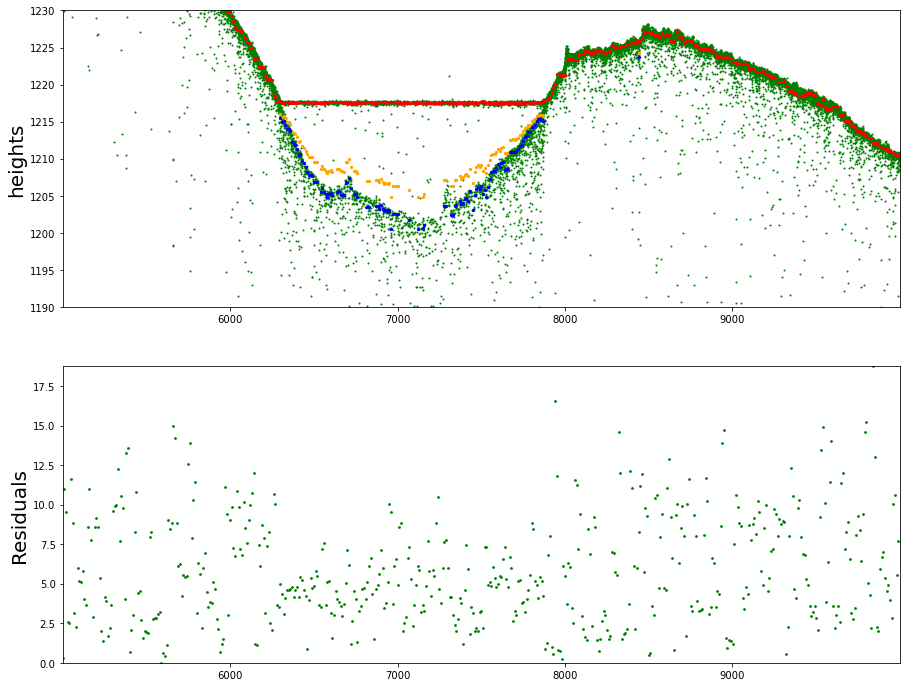

In [126]:
fig,ax=plt.subplots(2,1,figsize=(15,12))

y1 = 'heights'
y2 = 'residual'

minVal1, maxVal1 = dfATL03[y1].min(skipna=True), dfATL03[y1].max()
ax[0].scatter(dfATL03.AT_dist.values,dfATL03.heights.values,c='g',s=1)
ax[0].scatter(df.AT_dist.values,df.Surf_mean.values,c='r',s=5)
ax[0].scatter(df.AT_dist.values,df.bed.values,c='orange',s=5)
ax[0].scatter(df.AT_dist.values,df.bed_new.values,c='b',s=5)
ax[0].set_ylabel(y1,fontsize=20)
ax[0].set_ylim(1190, 1230);
ax[0].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal2, maxVal2 = df[y2].min(skipna=True), df[y2].max()
ax[1].scatter(df.AT_dist.values,df.residual.values,c='g',s=3)
ax[1].set_ylabel("Residuals",fontsize=20)
ax[1].set_ylim(minVal2, maxVal2);
ax[1].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);


Lake_Surf-function classifies lakes by looking at the flatness of the surface

In [105]:
def Lake_Surf(df_Surf, window_width):

    startTime = time.time()
    
    AT_dist_values = df_Surf['AT_dist'].values # Along Track Distance Values
    AT_dist_totmax = AT_dist_values.max()
    AT_dist_totmin = AT_dist_values.min()
    Residual_values = df_Surf['residual'].values
    Surf_values = df_Surf['Surf_mean'].values
    lats = df_Surf['lats'].values
    lons = df_Surf['lons'].values
    depth_surf = df_Surf['depth'].values

    
    windows = np.arange(AT_dist_totmin, AT_dist_totmax, 10).tolist()
    a = np.empty(len(windows))
    b = np.empty(len(windows))
    c = np.empty(len(windows))
    d = np.empty(len(windows))
    e = np.empty(len(windows))
    f = np.empty(len(windows))
    
    i = 0
    #Iterate through rows in dataframe
    for window_center in windows:    
        #---------------
        #Step 1: Window Boundries
        #---------------

        #Get minimum window boundries
        min_dist = window_center - window_width
        min_dist_array = np.where(AT_dist_values > min_dist)
        min_dist_row = min_dist_array[0][0]

        #Get maximum window boundries
        max_dist = window_center + window_width
        if max_dist < AT_dist_values[-1]:
            max_dist_array = np.where(AT_dist_values > max_dist)
            max_dist_row = max_dist_array[0][0]
        else:
            max_dist = AT_dist_values[-1] 

        #Select photons AT_dist & heights within boundries
        window_AT_dist = AT_dist_values[min_dist_row:max_dist_row]    
        window_heights = Surf_values[min_dist_row:max_dist_row]
        std1 = window_heights.std()
        print("std", std1)
        
        w_len = len(window_heights)
        print("wlen",w_len)
        if w_len > (window_width/6):
            res = Residual_values[i]
            lat = lats[i]
            lon = lons[i]
            depth = depth_surf[i]
            print("wc",window_center)
            print("res",res)
        
        #---------------
        #Step 2: Basic stats
        #---------------
        #Basic stats - mean & std
            std = window_heights.std()
            if (std < 0.1) & (res > 1):
                lakesurf = 1
            else:
                lakesurf = 0

            #------------------
            #Step 3: Outputs
            #------------------

            a[i] = window_center
            b[i] = lakesurf
            c[i] = std
            d[i] = lat
            e[i] = lon
            f[i] = depth
            #    e[i] = slope85
            i += 1
        else: 
            i += 1
        wincen = int(window_center)
        if wincen % 1000 < 1:  
            m = int(i / len(windows) * 100)
            print(m, "% Done")

    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(a, columns = ['AT_dist']) 
    df["lakesurf"] = b
    df["std1"] = c
    df["lat"] = d
    df["lon"] = e
    df["depth"] = f
    
#    df["slope"] = d

    # Script Runtime
    runTime =  int(time.time() - startTime)
    runTimeMin = runTime/60
    runTimeSec = runTime%60
    print("\nScript Runtime: %i minutes and %i seconds" % (runTimeMin,runTimeSec))
    
    return df

In [106]:
df2 = Lake_Surf(df, 200)

std 1.9180078583453932
wlen 21
0 % Done
std 2.033427161575366
wlen 22
std 2.121178209419345
wlen 23
std 2.1793733712942593
wlen 24
std 2.233190017403301
wlen 25
std 2.3619644630441305
wlen 26
std 2.476985722037384
wlen 27
std 2.568991378067364
wlen 28
std 2.651629605330283
wlen 29
std 2.745780479094375
wlen 30
std 2.822824029629655
wlen 31
std 2.936743559011898
wlen 32
std 3.0523523599433093
wlen 33
std 3.2028148577769007
wlen 34
wc 5130.5
res 2472.5888671875
std 3.3283561167094238
wlen 35
wc 5140.5
res 3255.61376953125
std 3.430605305265561
wlen 36
wc 5150.5
res 2853.117431640625
std 3.5236948383635274
wlen 37
wc 5160.5
res 3010.76708984375
std 3.60281131878873
wlen 38
wc 5170.5
res 1885.454345703125
std 3.721670140788228
wlen 39
wc 5180.5
res 1621.4464111328125
std 3.823507926416784
wlen 40
wc 5190.5
res 3092.72998046875
std 3.839101457333209
wlen 40
wc 5200.5
res 2917.404541015625
std 3.830691500929627
wlen 40
wc 5210.5
res 3134.517822265625
std 3.854842751832492
wlen 40
wc 5220.5
r

std 1.0876443875551707
wlen 40
wc 9080.5
res 1130.736572265625
std 1.0925724386920443
wlen 40
wc 9090.5
res 1965.826904296875
std 1.1040289163154227
wlen 40
wc 9100.5
res 2070.8212890625
std 1.110091145570422
wlen 40
wc 9110.5
res 3074.89892578125
std 1.1347817858700469
wlen 40
wc 9120.5
res 2886.011474609375
std 1.1529994434239406
wlen 40
wc 9130.5
res 4376.91259765625
std 1.2008303621299083
wlen 40
wc 9140.5
res 4699.92236328125
std 1.2436999641130078
wlen 40
wc 9150.5
res 3348.03271484375
std 1.2779347326023471
wlen 40
wc 9160.5
res 3662.0048828125
std 1.3024750097059823
wlen 40
wc 9170.5
res 1243.6474609375
std 1.319320547105593
wlen 40
wc 9180.5
res 2921.557861328125
std 1.3446866863511853
wlen 40
wc 9190.5
res 3141.177734375
std 1.37952100887555
wlen 40
wc 9200.5
res 2826.58154296875
std 1.404151377696589
wlen 40
wc 9210.5
res 2934.6279296875
std 1.424517357596838
wlen 40
wc 9220.5
res 1747.0498046875
std 1.4409584622142178
wlen 40
wc 9230.5
res 2295.66552734375
std 1.43574488997

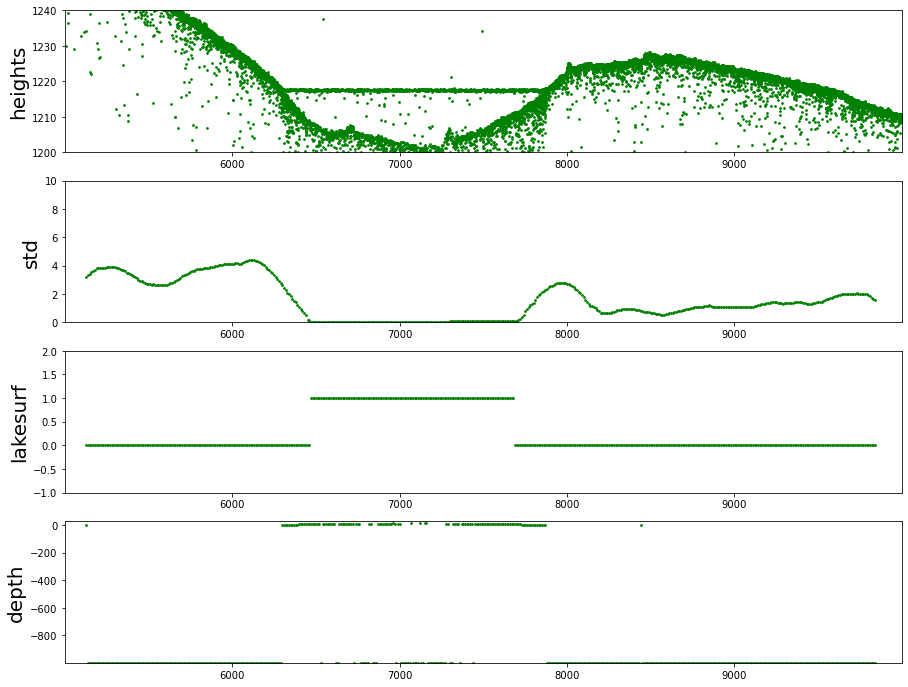

In [109]:
fig,ax=plt.subplots(4,1,figsize=(15,12))

y1 = 'heights'
y2 = 'std1'
y3 = 'lakesurf'
y4 = 'depth'
minVal1, maxVal1 = dfATL03[y1].min(skipna=True), dfATL03[y1].max()
ax[0].scatter(dfATL03.AT_dist.values,dfATL03.heights.values,c='g',s=3)
ax[0].scatter(df2.AT_dist.values,df2.lakesurf.values,c='r',s=3)
ax[0].set_ylabel(y1,fontsize=20)
ax[0].set_ylim(1200, 1240);
ax[0].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal2, maxVal2 = df2[y2].min(skipna=True), df2[y2].max()
ax[1].scatter(df2.AT_dist.values,df2.std1.values,c='g',s=3)
ax[1].set_ylabel("std",fontsize=20)
ax[1].set_ylim(0, 10);
ax[1].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal3, maxVal3 = df2[y3].min(skipna=True), df2[y3].max()
ax[2].scatter(df2.AT_dist.values,df2.lakesurf.values,c='g',s=3)
ax[2].set_ylabel("lakesurf",fontsize=20)
ax[2].set_ylim(-1, 2);
ax[2].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal4, maxVal4 = df2[y4].min(skipna=True), df2[y3].max()
ax[3].scatter(df2.AT_dist.values,df2.depth.values,c='g',s=3)
ax[3].set_ylabel("depth",fontsize=20)
ax[3].set_ylim(minVal4, 30);
ax[3].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);


Lake_Surf_Edge-function insures that the depth at the edges of supraglacial lakes are also calculated. 

In [111]:
def Lake_Surf_Edge(df_Lake_Surf, window_width):
    
    AT_dist_values = df_Lake_Surf['AT_dist'].values
    AT_dist_values = AT_dist_values.astype(int)
    Surf_search = df_Lake_Surf['lakesurf'].values
    lats = df_Lake_Surf['lat'].values
    lons = df_Lake_Surf['lon'].values
    depth_lake_surf = df_Lake_Surf['depth'].values
    
    AT_dist_totmax = AT_dist_values.max()
    print("max:",AT_dist_totmax)
    AT_dist_totmin = AT_dist_values.min()
    windows = np.arange(AT_dist_totmin, AT_dist_totmax, 10).tolist()
    i = 0
    
    a = np.empty(len(windows))
    b = np.empty(len(windows))
    c = np.empty(len(windows))
    d = np.empty(len(windows))
    f = np.empty(len(windows))
    
    df_len = len(Surf_search)
    df_len2 = len(windows)
    print("len1", df_len)
    print("len2", df_len2)
    
    
    for window_center in windows:
        
        if window_center < AT_dist_totmax:
            print("WC",window_center)
            #---------------
            #Step 1: Window Boundries
            #---------------

            #Get minimum window boundries
            min_dist = window_center - window_width
            min_dist_array = np.where(AT_dist_values > min_dist)
            min_dist_row = min_dist_array[0][0]

            #Get maximum window boundries
            max_dist = window_center + window_width
            if max_dist < AT_dist_values[-1]:
                max_dist_array = np.where(AT_dist_values > max_dist)
                max_dist_row = max_dist_array[0][0]
            else:
                max_dist = AT_dist_values[-1] 

            #Select photons AT_dist & heights within boundries
            window_AT_dist = AT_dist_values[min_dist_row:max_dist_row]    
    #        window_heights = Surf_values[min_dist_row:max_dist_row]
            window_surf = Surf_search[min_dist_row:max_dist_row]
        
            w_len = len(window_surf)
            print("wlen",w_len)
            print("at_dist", window_AT_dist)
            lake_search = 1 in window_surf
            lat = lats[i]
            lon = lons[i]
            depth = depth_lake_surf[i]
            print("i", i)
            print("lat i", lat)
            
            a[i] = window_center
            c[i] = lat
            d[i] = lon
            f[i] = depth
            
            if lake_search is True:
                lakesurfedge = 1
                b[i] = lakesurfedge
                i += 1
            else:
                lakesurfedge = 0
                b[i] = lakesurfedge
                i += 1

            wincen = int(window_center)
            if wincen % 1000 < 1:  
                m = int(i / len(windows) * 100)
                print(m, "% Done")

    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(a, columns = ['AT_dist']) 
    df["lakesurfedge"] = b
    df["lat"] = c
    df["lon"] = d
    df["depth"] = f
                  
    return df    

In [112]:
df3 = Lake_Surf_Edge(df2, 160)

max: 9980
len1 499
len2 498
WC 5000
wlen 17
at_dist [5000 5010 5020 5030 5040 5050 5060 5070 5080 5090 5100 5110 5120 5130
 5140 5150 5160]
i 0
lat i 68.96306006613683
0 % Done
WC 5010
wlen 18
at_dist [5000 5010 5020 5030 5040 5050 5060 5070 5080 5090 5100 5110 5120 5130
 5140 5150 5160 5170]
i 1
lat i 68.96314853212927
WC 5020
wlen 19
at_dist [5000 5010 5020 5030 5040 5050 5060 5070 5080 5090 5100 5110 5120 5130
 5140 5150 5160 5170 5180]
i 2
lat i 68.96323696224236
WC 5030
wlen 20
at_dist [5000 5010 5020 5030 5040 5050 5060 5070 5080 5090 5100 5110 5120 5130
 5140 5150 5160 5170 5180 5190]
i 3
lat i 68.96332539006964
WC 5040
wlen 21
at_dist [5000 5010 5020 5030 5040 5050 5060 5070 5080 5090 5100 5110 5120 5130
 5140 5150 5160 5170 5180 5190 5200]
i 4
lat i 68.96341382027224
WC 5050
wlen 22
at_dist [5000 5010 5020 5030 5040 5050 5060 5070 5080 5090 5100 5110 5120 5130
 5140 5150 5160 5170 5180 5190 5200 5210]
i 5
lat i 68.96350219448925
WC 5060
wlen 23
at_dist [5000 5010 5020 5030 504

WC 8270
wlen 32
at_dist [8120 8130 8140 8150 8160 8170 8180 8190 8200 8210 8220 8230 8240 8250
 8260 8270 8280 8290 8300 8310 8320 8330 8340 8350 8360 8370 8380 8390
 8400 8410 8420 8430]
i 327
lat i 68.99216340506887
WC 8280
wlen 32
at_dist [8130 8140 8150 8160 8170 8180 8190 8200 8210 8220 8230 8240 8250 8260
 8270 8280 8290 8300 8310 8320 8330 8340 8350 8360 8370 8380 8390 8400
 8410 8420 8430 8440]
i 328
lat i 68.99225157500491
WC 8290
wlen 32
at_dist [8140 8150 8160 8170 8180 8190 8200 8210 8220 8230 8240 8250 8260 8270
 8280 8290 8300 8310 8320 8330 8340 8350 8360 8370 8380 8390 8400 8410
 8420 8430 8440 8450]
i 329
lat i 68.99233978583915
WC 8300
wlen 32
at_dist [8150 8160 8170 8180 8190 8200 8210 8220 8230 8240 8250 8260 8270 8280
 8290 8300 8310 8320 8330 8340 8350 8360 8370 8380 8390 8400 8410 8420
 8430 8440 8450 8460]
i 330
lat i 68.99242805074395
WC 8310
wlen 32
at_dist [8160 8170 8180 8190 8200 8210 8220 8230 8240 8250 8260 8270 8280 8290
 8300 8310 8320 8330 8340 8350 83

In [113]:
#df3 = df3.loc[df3['lakesurfedge'] == 1]
df3

,AT_dist,lakesurfedge,lat,lon,depth
0,5000.0,0.0,68.963060,1258.840430,1633.103149
1,5010.0,0.0,68.963149,1258.840430,1765.703735
2,5020.0,0.0,68.963237,1258.840430,1959.373779
3,5030.0,0.0,68.963325,1258.840430,1961.644897
4,5040.0,0.0,68.963414,1257.625244,1118.280884
...,...,...,...,...,...
493,9930.0,0.0,69.006940,1211.012793,1211.996826
494,9940.0,0.0,69.007029,1211.012793,1314.497070
495,9950.0,0.0,69.007117,1210.857520,2663.219238
496,9960.0,0.0,69.007212,1210.857520,2406.501221


In [114]:
df = pd.DataFrame(df3)
df

,AT_dist,lakesurfedge,lat,lon,depth
0,5000.0,0.0,68.963060,1258.840430,1633.103149
1,5010.0,0.0,68.963149,1258.840430,1765.703735
2,5020.0,0.0,68.963237,1258.840430,1959.373779
3,5030.0,0.0,68.963325,1258.840430,1961.644897
4,5040.0,0.0,68.963414,1257.625244,1118.280884
...,...,...,...,...,...
493,9930.0,0.0,69.006940,1211.012793,1211.996826
494,9940.0,0.0,69.007029,1211.012793,1314.497070
495,9950.0,0.0,69.007117,1210.857520,2663.219238
496,9960.0,0.0,69.007212,1210.857520,2406.501221


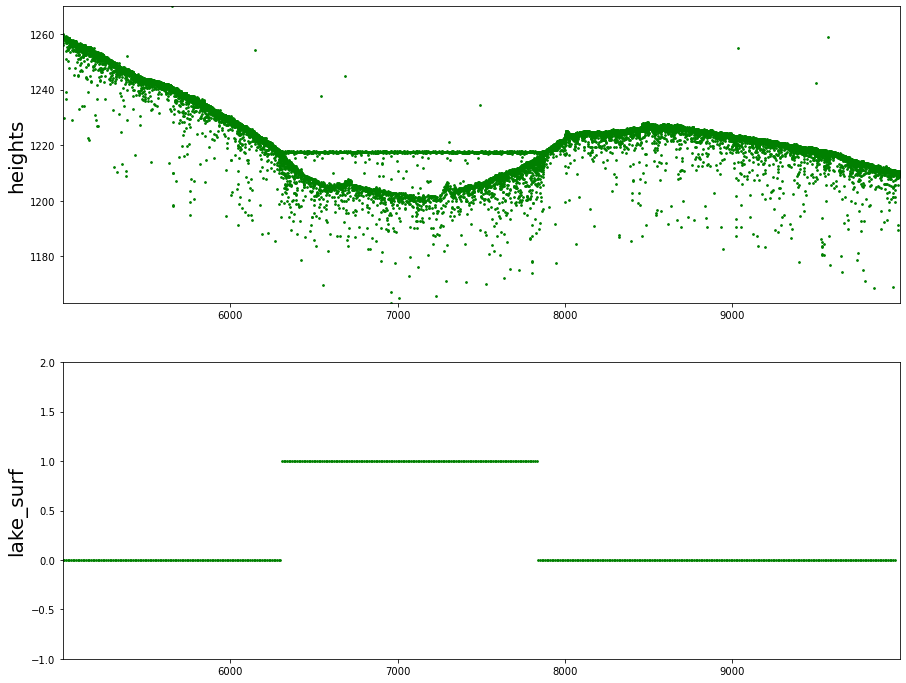

In [115]:
fig,ax=plt.subplots(2,1,figsize=(15,12))

y1 = 'heights'
y2 = 'lakesurfedge'
y3 = 'lakesurf'
minVal1, maxVal1 = dfATL03[y1].min(skipna=True), dfATL03[y1].max()
ax[0].scatter(dfATL03.AT_dist.values,dfATL03.heights.values,c='g',s=3)
ax[0].scatter(df.AT_dist.values,df.lakesurfedge.values,c='r',s=5)
ax[0].set_ylabel(y1,fontsize=20)
ax[0].set_ylim(minVal1, maxVal1);
ax[0].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);

minVal2, maxVal2 = df[y2].min(skipna=True), df[y2].max()
ax[1].scatter(df.AT_dist.values,df.lakesurfedge.values,c='g',s=3)
ax[1].set_ylabel("lake_surf",fontsize=20)
ax[1].set_ylim(-1, 2);
ax[1].set_xlim(dfATL03.AT_dist.values[0],dfATL03.AT_dist.values[-1]);


In [116]:
df5 = df3.loc[df3['lakesurfedge'] == 1]
df = df5.loc[df5['depth'] != -999]

In [117]:
from pyproj import Proj
pp = Proj(proj='utm',zone=22,ellps='WGS84', preserve_units=False)

xx, yy = pp(df["lon"].values, df["lat"].values)
df["X"] = xx
df["Y"] = yy 

In [118]:
from shapely.geometry import Point

# combine lat and lon column to a shapely Point() object
df['geometry'] = df.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)

In [119]:
import geopandas
df = geopandas.GeoDataFrame(df, geometry='geometry')

Output is used as training data in regression analysis with optical imagery

In [120]:
df.to_file('Geometry.shp', driver='ESRI Shapefile')